In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import seaborn as sns

import lrp
import utility

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Load the dataset and classifier

In [2]:
# Valid datasets are "MNIST" and "CIFAR10"
dataset = "CIFAR10" 
# You can either train a model or load a model
mode = "load"

In order to recieve the best results with this LRP implementation, the input data is scaled to the values [-1,...,1]

In [3]:
(x_train, y_train, x_test, y_test) = utility.load_dataset(dataset)

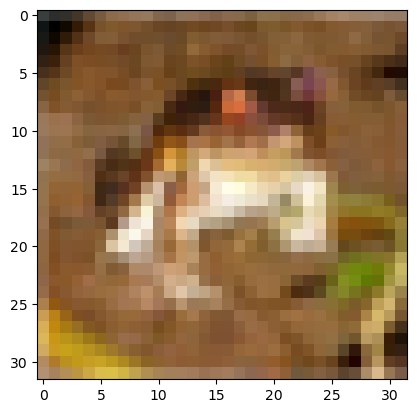

In [4]:
if x_train[0,...].shape[2] == 1:
    plt.imshow(((x_train[0,...]+1)/2)[:,:,0],cmap='gray')
else:
    plt.imshow(((x_train[0,...]+1)/2)[:,:,:])

# Train a model or load a model

In [5]:
classifier = utility.get_classifier(dataset = dataset, mode = mode, data = (x_train, y_train, x_test, y_test), save_model = False)

Loading model ...


### Create an explainer object

In [6]:
# To define an LRP explainer, you have to define an LRP-process
if dataset == "MNIST":
    lrp_process = ["final", "ab", "avg", "ab", "ab", "avg", "flatten", "eps", "0"]
elif dataset == "CIFAR10":
    lrp_process = ["final", "ab", "max", "ab", "ab", "avg", "ab", "ab", "ab", "avg", "ab", "ab", "ab", "avg", "ab", "ab", "ab", "avg", "flatten", "eps","eps", "0"]

In [7]:
explainer = lrp.LrpExplainer(classifier, 
                             lrp_process, # This LRP process must define a rule for each layer. for reference what rule to choose, see here: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
                             a = 2, b = -1,  # These are hyper parameters a & b, according to LRP specificationsw
                             verbose = True) # Enables additional printouts and returns of the relprop function

### As verbose is True, additional logs are printed and returned

In [8]:
img = x_test[6,...]
label = y_test[6,...]

calculating LRP of  <keras.engine.functional.Functional object at 0x0000018A9EB873D0>
['final', 'ab', 'max', 'ab', 'ab', 'avg', 'ab', 'ab', 'ab', 'avg', 'ab', 'ab', 'ab', 'avg', 'ab', 'ab', 'ab', 'avg', 'flatten', 'eps', 'eps', '0']
###################
getting values
propagating relevance regarding classification:  1
In layer  -1  :  <keras.layers.core.dense.Dense object at 0x0000018A9F7A0AC0>  check-value:  1.00352347296946
In layer  -2  :  <keras.layers.core.dense.Dense object at 0x0000018A9F7A0A90>  check-value:  1.0142347901927353
In layer  -3  :  <keras.layers.reshaping.flatten.Flatten object at 0x0000018A9F7A0790>  check-value:  1.0142347901927353
In layer  -4  :  <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000018AA7F3C3A0>  check-value:  1.014235
In layer  -5  :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000018AA7FBFEB0>  check-value:  1.0142345
In layer  -6  :  <keras.layers.convolutional.conv2d.Conv2D object at 0x0000018AA7FBFBE0>  check-value:  

Text(0.5, 1.0, '$y_{true}$ = 1, $y_{pred}$ = 1')

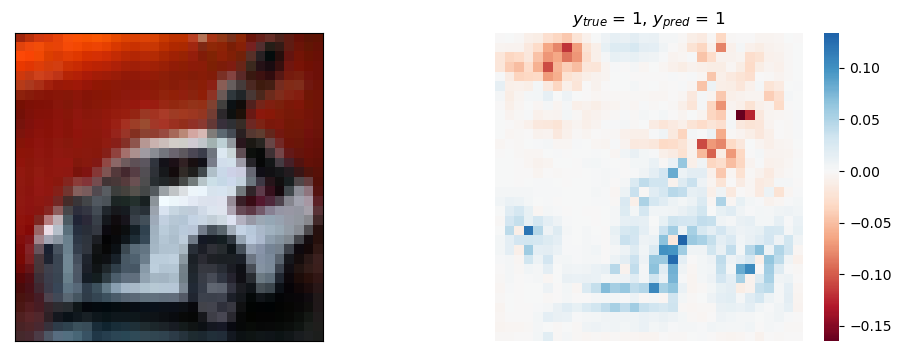

In [9]:
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12,4))
R, inputs, outputs, weights, biases, rs = explainer.relprop(img, label)
for a in axs:
    a.axes.xaxis.set_visible(False)
    a.axes.yaxis.set_visible(False)
if img.shape[2] == 1:
    axs[0].imshow(((img+1)/2)[:,:,0],cmap='gray')
else:
    axs[0].imshow(((img+1)/2)[:,:,:])
y_pred = classifier.predict(img.reshape([1]+list(img.shape)))
sns.heatmap(R[0,:,:,:].sum(axis=-1),center=0, vmax=np.max(R[0,:,:,:].sum(axis=-1)), vmin=np.min(R[0,:,:,:].sum(axis=-1)),cmap="RdBu", square = True, ax = axs[1])
axs[1].set_title(str('$y_{true}$'+" = "+str(np.argmax(label))+ ', $y_{pred}$'+" = "+str(np.argmax(y_pred))))

## Creating an adversarial attack and checking out the result

For the sake of this demonstration, we set verbose to False as to not get too many relprop log printouts.

The first run is without early_stopping enabled.

In [10]:
explainer.verbose = False

In [11]:
adv_img_flip = explainer.flip_attack(img, label, flips = 100, early_stopping = False)
adv_img_ifgsm = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = False)
adv_img_lrp = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 40, eps = 2/256, early_stopping = False)
adv_imgs = dict({"flip": utility.transform_image(adv_img_flip),
                "ifgsm": utility.transform_image(adv_img_ifgsm),
                "lrp": utility.transform_image(adv_img_lrp)})

1/1 [==============================] - 0s 26ms/step


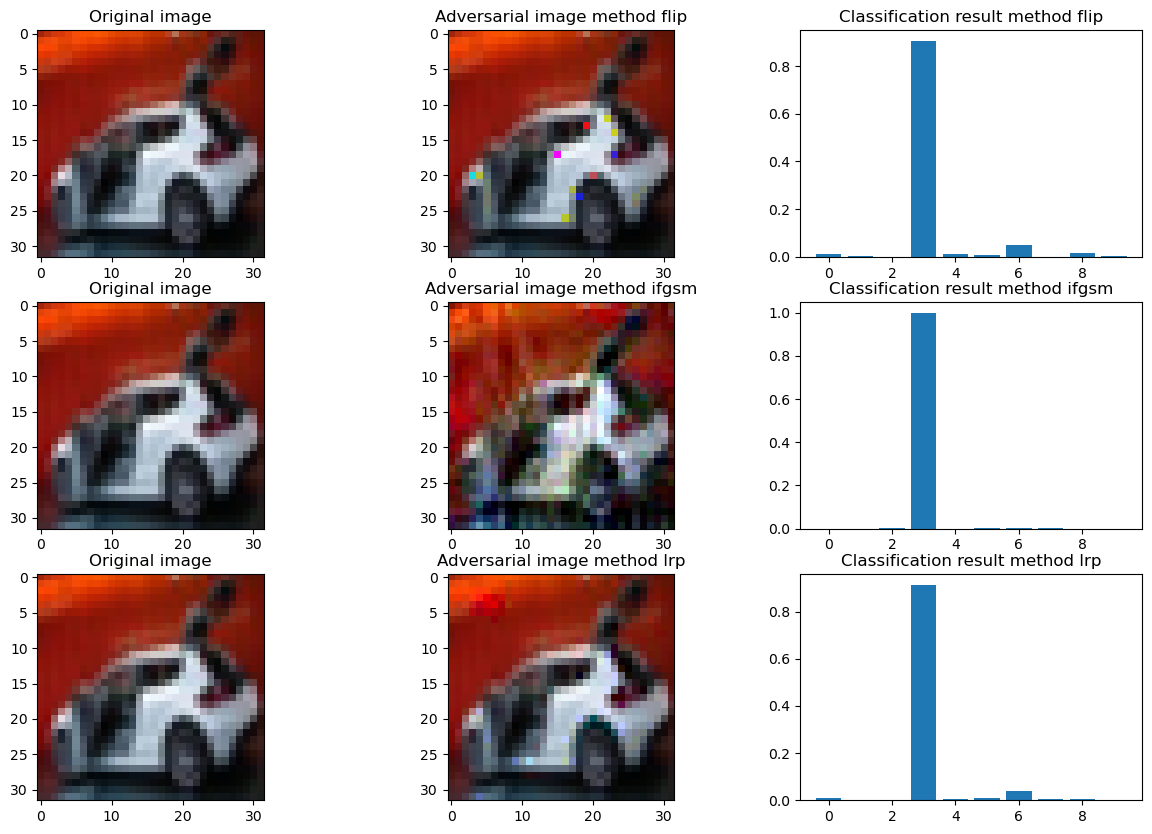

In [12]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))

for i, method in enumerate(adv_imgs.keys()):
    if img.shape[-1] == 1:
        axs[i,0].imshow(utility.transform_image(img),cmap='gray')
        axs[i,1].imshow(adv_imgs[method],cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,0].imshow(utility.transform_image(img))
        axs[i,1].imshow(adv_imgs[method])
    axs[i,0].set_title("Original image")
    axs[i,1].set_title(f"Adversarial image method {method}")
    axs[i,2].bar(range(0,10), classifier.predict(adv_imgs[method].reshape([1]+ list(adv_imgs[method].shape)))[0])
    axs[i,2].set_title(f"Classification result method {method}")

Enabling early stopping leads to reduced manipulation of adversarial images.

In [13]:
adv_img_flip = explainer.flip_attack(img, label, flips = 100, early_stopping = True)
adv_img_ifgsm = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = True)
adv_img_lrp = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 20, eps = 2/256, early_stopping = True)
adv_imgs = dict({"flip": utility.transform_image(adv_img_flip),
                "ifgsm": utility.transform_image(adv_img_ifgsm),
                "lrp": utility.transform_image(adv_img_lrp)})

1/1 [==============================] - 0s 25ms/step


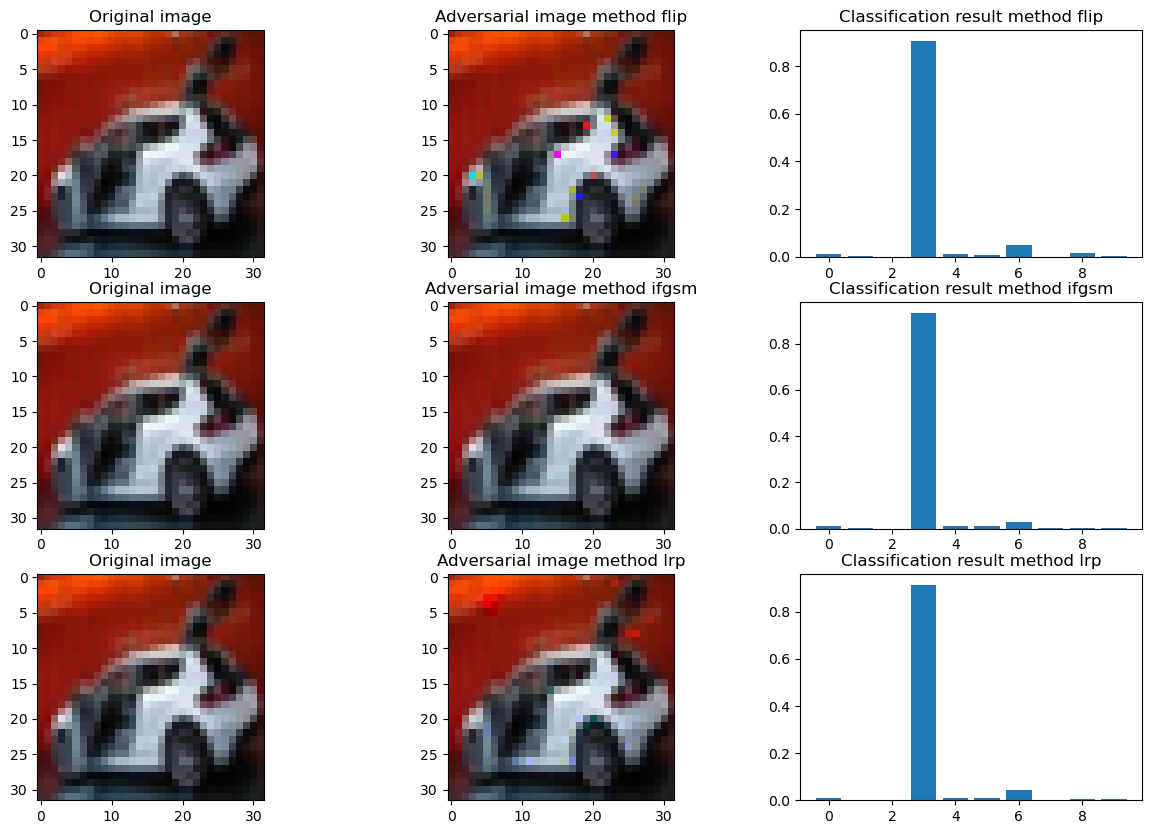

In [14]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))

for i, method in enumerate(adv_imgs.keys()):
    if img.shape[-1] == 1:
        axs[i,0].imshow(utility.transform_image(img),cmap='gray')
        axs[i,1].imshow(adv_imgs[method],cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,0].imshow(utility.transform_image(img))
        axs[i,1].imshow(adv_imgs[method])
    axs[i,0].set_title("Original image")
    axs[i,1].set_title(f"Adversarial image method {method}")
    axs[i,2].bar(range(0,10), classifier.predict(adv_imgs[method].reshape([1]+ list(adv_imgs[method].shape)))[0])
    axs[i,2].set_title(f"Classification result method {method}")

The following graph highlights the improvement in image manupulation that early stopping delivers

In [30]:
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (20,12))
methods = ["flip", "ifgsm", "lrp"]
for i, method in enumerate(methods):
    if method == "flip":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.flip_attack(img, label, flips = 100, early_stopping = False, log = True)
    elif method == "ifgsm":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = False, log = True)
    elif method == "lrp":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 40, eps = 2/256, early_stopping = False, log = True)

    if img.shape[-1] == 1:
        axs[i,0].imshow(utility.transform_image(img),cmap='gray')
        axs[i,1].imshow(utility.transform_image(adv_img),cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,0].imshow(utility.transform_image(img))
        axs[i,1].imshow(utility.transform_image(adv_img))
    axs[i,0].set_title("Original image")
    axs[i,1].set_title(f"adv image method {method}")    
    axs[i,2].set_title(f"Confidences method {method}")
    axs[i,2].plot(np.array(y_log)[:,[y_log[-1].argmax()]], c = "dodgerblue", label = "$c_{new}$")
    axs[i,2].plot(np.array(y_log)[:,[label.argmax()]], c = "gray", label = "$c_{original}$")
    axs[i,2].legend()

    if method == "flip":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.flip_attack(img, label, flips = 100, early_stopping = True, log = True)
    elif method == "ifgsm":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = True, log = True)
    elif method == "lrp":
        adv_img, y, y_new, y_log, r_log, img_log = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 40, eps = 2/256, early_stopping = True, log = True)
    
    if img.shape[-1] == 1:
        axs[i,3].imshow(utility.transform_image(adv_img),cmap='gray')
    elif img.shape[-1] == 3:
        axs[i,3].imshow(utility.transform_image(adv_img))
    axs[i,3].set_title(f"adv image method {method}, early stop")    
    axs[i,4].set_title(f"Confidences method {method}, early stop")
    axs[i,4].plot(np.array(y_log)[:,[y_log[-1].argmax()]], c = "dodgerblue", label = "$c_{new}$")
    axs[i,4].plot(np.array(y_log)[:,[label.argmax()]], c = "gray", label = "$c_{original}$")
    axs[i,4].legend()


In [90]:
flipped_img, y, y_new, y_log, r_log, img_log = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256, early_stopping = True, log = True)

In [24]:
np.array(y_log).argmax(axis = 1)

array([1, 1, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64)

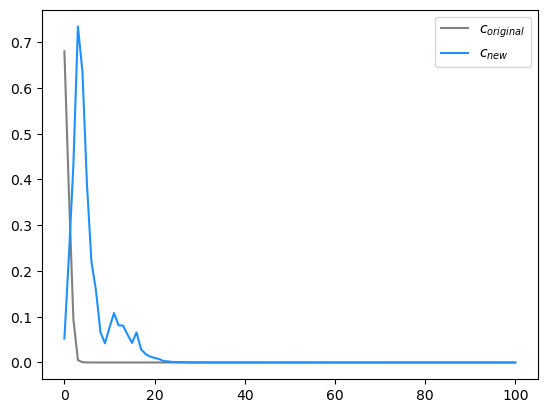

In [21]:
plt.plot(np.array(y_log)[:,[label.argmax()]], c = "gray", label = "$c_{original}$")
plt.plot(np.array(y_log)[:,[y_new.argmax()]], c = "dodgerblue", label = "$c_{new}$")
plt.legend()